In [ ]:
import numpy as np
import pandas as pd
import math

# Parameters
num_samples = 100000  # Number of synthetic data points
kp = 0.5  # Proportional gain for speed control
max_throttle = 0.7
max_brake = 1.0
epsilon = 1e-3  # Small value to prevent division by zero
target_distance = 10.0  # Desired distance in meters

def normalize_angle(angle):
    while angle > math.pi:
        angle -= 2.0 * math.pi
    while angle < -math.pi:
        angle += 2.0 * math.pi
    return angle

# Generate synthetic data
data = []
for _ in range(num_samples):
    # Randomly sample input values
    lead_speed = np.random.uniform(0, 30)  # Lead vehicle speed (m/s)
    follower_speed = np.random.uniform(0, 30)  # Follower vehicle speed (m/s)
    lead_yaw = np.random.uniform(-math.pi, math.pi)  # Lead vehicle yaw (radians)
    follower_yaw = np.random.uniform(-math.pi, math.pi)  # Follower vehicle yaw (radians)
    distance = np.random.uniform(5, 20)  # Distance between vehicles (m)

    # Compute desired speed and control outputs
    speed_error = (distance - target_distance)
    desired_speed = lead_speed + kp * speed_error
    throttle = min(max_throttle, (desired_speed - follower_speed) / (desired_speed + epsilon)) if desired_speed > follower_speed else 0
    brake = min(max_brake, (follower_speed - desired_speed) / (follower_speed + epsilon)) if desired_speed < follower_speed else 0

    # Compute steering control
    yaw_error = normalize_angle(lead_yaw - follower_yaw)
    steer = max(-1.0, min(1.0, yaw_error * kp))

    # Store the data point
    data.append([lead_speed, follower_speed, lead_yaw, follower_yaw, throttle, brake, steer])

# Save to a CSV file
df = pd.DataFrame(data, columns=["lead_speed", "follower_speed", "lead_yaw", "follower_yaw", "throttle", "brake", "steer"])
df.to_csv("synthetic_training_data.csv", index=False)
print("Synthetic training data saved.")

Synthetic training data saved.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
import json

# Load synthetic data
df = pd.read_csv("synthetic_training_data.csv")
X = df[["lead_speed", "follower_speed", "lead_yaw", "follower_yaw"]].values
y = df[["throttle", "brake", "steer"]].values

# Scale inputs and outputs for normalized range [0, 1]
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Train an MLP regressor
mlp = MLPRegressor(hidden_layer_sizes=(16, 8), activation='relu', max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

# Save the model's weights and biases
model_data = {
    "coefs": [coef.tolist() for coef in mlp.coefs_],
    "intercepts": [intercept.tolist() for intercept in mlp.intercepts_],
    "scaler_X_min": scaler_X.min_.tolist(),
    "scaler_X_scale": scaler_X.scale_.tolist(),
    "scaler_y_min": scaler_y.min_.tolist(),
    "scaler_y_scale": scaler_y.scale_.tolist()
}

with open("mlp_model.json", "w") as f:
    json.dump(model_data, f)

print("Model trained and exported.")


Model trained and exported.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import json

# Load synthetic data
df = pd.read_csv("synthetic_training_data.csv")
X = df[["lead_speed", "follower_speed", "lead_yaw", "follower_yaw"]].values
y = df[["throttle", "brake", "steer"]].values

# Scale inputs and outputs for normalized range [0, 1]
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Train an MLP regressor with robust settings
mlp = MLPRegressor(
    hidden_layer_sizes=(32, 16),  # More neurons for robustness
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    max_iter=10000,
    random_state=42,
    verbose=True  # Display loss during training
)

# Fit the model and monitor performance
mlp.fit(X_train, y_train)

# Evaluate performance on the test set
y_pred_scaled = mlp.predict(X_test)
mse = mean_squared_error(y_test, y_pred_scaled)
mae = mean_absolute_error(y_test, y_pred_scaled)
print(f"Test MSE: {mse:.6f}, Test MAE: {mae:.6f}")

# Rescale predictions back to original range
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test)

# Display predictions vs. ground truth
for i in range(5):  # Display first 5 test samples
    print(f"Ground Truth: {y_test_original[i]}, Prediction: {y_pred[i]}")

# # Visualize predictions vs. ground truth
# plt.figure(figsize=(10, 6))
# plt.plot(y_test_original[:, 0], label='Ground Truth Throttle', color='blue', alpha=0.7)
# plt.plot(y_pred[:, 0], label='Predicted Throttle', color='red', linestyle='dashed', alpha=0.7)
# plt.title("Throttle Predictions vs Ground Truth")
# plt.legend()
# plt.show()

# plt.figure(figsize=(10, 6))
# plt.plot(y_test_original[:, 1], label='Ground Truth Brake', color='blue', alpha=0.7)
# plt.plot(y_pred[:, 1], label='Predicted Brake', color='red', linestyle='dashed', alpha=0.7)
# plt.title("Brake Predictions vs Ground Truth")
# plt.legend()
# plt.show()

# plt.figure(figsize=(10, 6))
# plt.plot(y_test_original[:, 2], label='Ground Truth Steer', color='blue', alpha=0.7)
# plt.plot(y_pred[:, 2], label='Predicted Steer', color='red', linestyle='dashed', alpha=0.7)
# plt.title("Steer Predictions vs Ground Truth")
# plt.legend()
# plt.show()

# Export the model for deployment
model_data = {
    "coefs": [coef.tolist() for coef in mlp.coefs_],
    "intercepts": [intercept.tolist() for intercept in mlp.intercepts_],
    "scaler_X_min": scaler_X.min_.tolist(),
    "scaler_X_scale": scaler_X.scale_.tolist(),
    "scaler_y_min": scaler_y.min_.tolist(),
    "scaler_y_scale": scaler_y.scale_.tolist()
}

with open("mlp_model.json", "w") as f:
    json.dump(model_data, f)

print("Model trained, evaluated, and exported.")


Iteration 1, loss = 0.04774215
Iteration 2, loss = 0.02390364
Iteration 3, loss = 0.01525778
Iteration 4, loss = 0.01240762
Iteration 5, loss = 0.01102800
Iteration 6, loss = 0.00953356
Iteration 7, loss = 0.00831228
Iteration 8, loss = 0.00743677
Iteration 9, loss = 0.00673367
Iteration 10, loss = 0.00615976
Iteration 11, loss = 0.00570508
Iteration 12, loss = 0.00538084
Iteration 13, loss = 0.00512845
Iteration 14, loss = 0.00495983
Iteration 15, loss = 0.00481580
Iteration 16, loss = 0.00471171
Iteration 17, loss = 0.00460580
Iteration 18, loss = 0.00452062
Iteration 19, loss = 0.00445426
Iteration 20, loss = 0.00440350
Iteration 21, loss = 0.00435533
Iteration 22, loss = 0.00429469
Iteration 23, loss = 0.00424084
Iteration 24, loss = 0.00417389
Iteration 25, loss = 0.00414038
Iteration 26, loss = 0.00410795
Iteration 27, loss = 0.00407482
Iteration 28, loss = 0.00406163
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Test MSE: 0.007849, Tes

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 7)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │            512 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 32)             │            256 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 32)             │          2,080 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 32)             │              0 │ dense_4[0][0],         │
│                           │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 16)             │            528 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 3)              │             51 │ dense_5[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,427 (13.39 KB)

 Trainable params: 3,427 (13.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 5.7489 - mae: 1.4213 - val_loss: 0.0908 - val_mae: 0.2342
Epoch 2/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0681 - mae: 0.1961 - val_loss: 0.0387 - val_mae: 0.1497
Epoch 3/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0358 - mae: 0.1433 - val_loss: 0.0265 - val_mae: 0.1255
Epoch 4/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0262 - mae: 0.1248 - val_loss: 0.0211 - val_mae: 0.1143
Epoch 5/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0214 - mae: 0.1139 - val_loss: 0.0201 - val_mae: 0.1111
Epoch 6/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0195 - mae: 0.1088 - val_loss: 0.0185 - val_mae: 0.1066
Epoch 7/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0182 - mae: 0.1050 - val_loss: 0.0172 - val_mae: 0.1033
Epoch 8/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0173 - mae: 0.1025 - val_loss: 0.0159 - val_mae: 0.0983
Epoch 9/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/

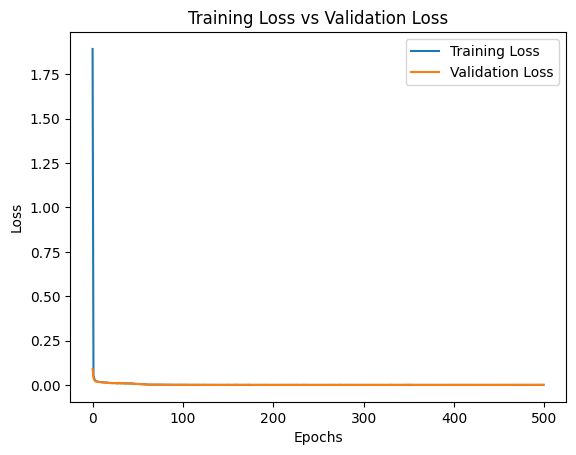

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Input: [24.93625511  8.67514603 -1.42296288 -2.36409353  8.85690079  0.94113065
 18.85690079]
True Output: [0.7        0.         0.47056532]
Predicted Output: [ 0.6979603  -0.00267635  0.44742665]
--------------------------------------------------
Input: [23.16844673 17.76751392 -0.41326429 -1.12994448  2.05591463  0.71668019
 12.05591463]
True Output: [0.7       0.        0.3583401]
Predicted Output: [ 0.70842737 -0.00261423  0.31716636]
--------------------------------------------------
Input: [28.1725358  14.31392714  1.95737604  1.3199125  -2.79539241  0.63746354
  7.20460759]
True Output: [0.         0.27953924 0.31873177]
Predicted Output: [0.0101255  0.27874577 0.28637454]
--------------------------------------------------
Input: [17.62603395 18.74460664 -1.79298319 -2.01335888  2.78980352  0.22037569
 12.78980352]
True Output: [0.7        0.         0.11018784]
Predicted Output: [ 0.7066797  -0.00244785  0.06999407]
----------------------

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Add
import matplotlib.pyplot as plt

# Helper Functions
def normalize_angle(angle):
    """Normalize an angle to the range [-pi, pi]."""
    while angle > np.pi:
        angle -= 2.0 * np.pi
    while angle < -np.pi:
        angle += 2.0 * np.pi
    return angle

# Generate Synthetic Training Data
def generate_synthetic_data(num_samples=10000, target_distance=10.0, max_speed=30.0):
    """
    Generate synthetic training data based on the platooning logic.
    """
    lead_speeds = np.random.uniform(0, max_speed, num_samples)
    follower_speeds = np.random.uniform(0, max_speed, num_samples)
    lead_yaws = np.random.uniform(-np.pi, np.pi, num_samples)
    follower_yaws = np.random.uniform(-np.pi, np.pi, num_samples)
    distances = np.random.uniform(5, 20, num_samples)

    # Calculate error terms
    speed_errors = distances - target_distance
    yaw_errors = [normalize_angle(lead_yaw - follower_yaw) for lead_yaw, follower_yaw in zip(lead_yaws, follower_yaws)]

    # Desired outputs (throttle, brake, steer)
    throttles = np.clip(speed_errors * 0.5, 0, 0.7)  # Linear relation for throttle
    brakes = np.clip(-speed_errors * 0.1, 0, 1.0)    # Brake for overspeed
    steers = np.clip(np.array(yaw_errors) * 0.5, -1.0, 1.0)  # Steer proportional to yaw error

    # Combine inputs and outputs
    inputs = np.column_stack((lead_speeds, follower_speeds, lead_yaws, follower_yaws, speed_errors, yaw_errors, distances))
    outputs = np.column_stack((throttles, brakes, steers))
    return inputs, outputs

# Generate Data
X, y = generate_synthetic_data()
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Define MLP Architecture
input_layer = Input(shape=(7,))
dense1 = Dense(64, activation='relu')(input_layer)
dense2 = Dense(32, activation='relu')(dense1)

# Project input to match dense2 dimensions for residual connection
projected_input = Dense(32, activation='linear')(input_layer)
residual = Add()([projected_input, dense2])  # Skip connection

dense3 = Dense(16, activation='relu')(residual)
output_layer = Dense(3, activation='linear')(dense3)

# Create and compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


# Custom Loss Function (Optional Gradient Matching)
@tf.function
def gradient_loss(y_true, y_pred, inputs):
    grad_true = tf.gradients(y_true, inputs)[0]  # True gradient
    grad_pred = tf.gradients(y_pred, inputs)[0]  # Predicted gradient
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    grad_loss = tf.reduce_mean(tf.square(grad_true - grad_pred))
    return mse_loss + grad_loss

# Training the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=500,
    batch_size=64,
    verbose=1
)

# Plot Training and Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Training Loss vs Validation Loss")
plt.show()

# Test the Model on New Data
def test_model(model, num_samples=10):
    """
    Test the model with new synthetic data.
    """
    X_test, y_true = generate_synthetic_data(num_samples)
    y_pred = model.predict(X_test)

    for i in range(num_samples):
        print(f"Input: {X_test[i]}")
        print(f"True Output: {y_true[i]}")
        print(f"Predicted Output: {y_pred[i]}")
        print('-' * 50)

test_model(model)


In [ ]:
# Save the model in TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save to a file
with open("platooning_model.tflite", "wb") as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpvqustf5r'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 7), dtype=tf.float32, name='keras_tensor_3')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  135425038804672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135425038809600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135425020004304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135425020003952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135425038804848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135425020002368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135425020009232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135425020010464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135425020011520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135425020013984: TensorSpec(shape=(), dtype=tf.resource, name=None)
